In [1]:
# Asegurarse de que se esté utilizando GPU
import tensorflow as tf
tf.test.gpu_device_name()

# Importación de Librerías
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from xml.etree import ElementTree
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
import numpy as np

In [ ]:
# Cargar el archivo .json con el token de Kaggle y utilizar la API de Kaggle para descargar el archivo .zip del dataset
from google.colab import files
files.upload()

# Crear el directorio .kaggle y mover el archivo kaggle.json allí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la API de Kaggle
!pip install kaggle

# Descargar el archivo del conjunto de datos de Kaggle
!kaggle datasets download -d karthika95/pedestrian-detection --unzip -p /content/pedestrian_dataset

In [3]:
# Se definen los nombres de las clases
class_names = ['person', 'person-like']
class_names_label = {name: i for i, name in enumerate(class_names)}

# Se definen los parámetros de la imagen
n_classes = 2
size = (200, 200)

In [4]:
# Función para cargar y procesar las imágenes y etiquetas desde los directorios específicos para conjuntos de datos de entrenamiento, prueba y validación
def load_data():
    datasets = ['Train/Train', 'Test/Test', 'Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = "/content/pedestrian_dataset/" + dataset + "/Annotations"
        directoryIMG = "/content/pedestrian_dataset/" + dataset + "/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:
            xmlf = os.path.join(directoryA, xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i += 1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

        labels = np.array(labels, dtype='int32')
        output.append((imags, labels))
    return output


In [5]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

In [ ]:
# Visualización de algunas imágenes
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.show()

In [82]:
# Extracción de HOG features
def extract_hog_features(images):
    hog_features_accum = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, hog_img = hog(img_gray,
                                orientations=12,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(2, 2),
                                transform_sqrt=True,
                                visualize=True,
                                feature_vector=True)
        hog_features_accum.append(features)
    return np.vstack(hog_features_accum).astype(np.float64)

In [83]:
train_features = extract_hog_features(train_images)
test_features = extract_hog_features(test_images)
val_features = extract_hog_features(val_images)

In [84]:
print("Shape de train_features:", train_features.shape)
print("Shape de train_labels:", train_labels.shape)

Shape de train_features: (944, 5808)
Shape de train_labels: (944,)


In [85]:
# Normalización de los datos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
val_features = scaler.transform(val_features)

In [86]:
# Creación del modelo de red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [118]:
model = Sequential()
#model.add(Dense(units=512, activation='relu', input_dim=train_features.shape[1]))
#model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [119]:
model.compile(optimizer='Adadelta',
              loss='binary_crossentropy', metrics=['accuracy'])

In [120]:
# Entrenamiento del modelo
history = model.fit(train_features, train_labels, validation_data=(val_features, val_labels), epochs=22, batch_size=32, verbose=2)

Epoch 1/22
30/30 - 2s - loss: 0.7355 - accuracy: 0.4725 - val_loss: 0.6899 - val_accuracy: 0.5625 - 2s/epoch - 78ms/step
Epoch 2/22
30/30 - 0s - loss: 0.7172 - accuracy: 0.5064 - val_loss: 0.6894 - val_accuracy: 0.5500 - 152ms/epoch - 5ms/step
Epoch 3/22
30/30 - 0s - loss: 0.7032 - accuracy: 0.5201 - val_loss: 0.6890 - val_accuracy: 0.5375 - 149ms/epoch - 5ms/step
Epoch 4/22
30/30 - 0s - loss: 0.7153 - accuracy: 0.5032 - val_loss: 0.6887 - val_accuracy: 0.5562 - 158ms/epoch - 5ms/step
Epoch 5/22
30/30 - 0s - loss: 0.7119 - accuracy: 0.5000 - val_loss: 0.6887 - val_accuracy: 0.5625 - 147ms/epoch - 5ms/step
Epoch 6/22
30/30 - 0s - loss: 0.7274 - accuracy: 0.5042 - val_loss: 0.6886 - val_accuracy: 0.5562 - 158ms/epoch - 5ms/step
Epoch 7/22
30/30 - 0s - loss: 0.7108 - accuracy: 0.5275 - val_loss: 0.6884 - val_accuracy: 0.5500 - 161ms/epoch - 5ms/step
Epoch 8/22
30/30 - 0s - loss: 0.6935 - accuracy: 0.5487 - val_loss: 0.6885 - val_accuracy: 0.5375 - 158ms/epoch - 5ms/step
Epoch 9/22
30/30 -

In [121]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_features, test_labels, verbose=2)
print("Test Accuracy: ", test_acc)

8/8 - 0s - loss: 0.6658 - accuracy: 0.6000 - 162ms/epoch - 20ms/step
Test Accuracy:  0.6000000238418579


In [16]:
# Predicción de etiquetas del conjunto de datos de prueba
test_predictions = (model.predict(test_features) > 0.5).astype("int32")

8/8 [==============================] - 0s 3ms/step


In [17]:
# Cálculo de la matriz de confusión y clasificación
conf_matrix = confusion_matrix(test_labels, test_predictions)
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       136
           1       0.68      0.54      0.60        99

    accuracy                           0.70       235
   macro avg       0.69      0.68      0.68       235
weighted avg       0.70      0.70      0.69       235



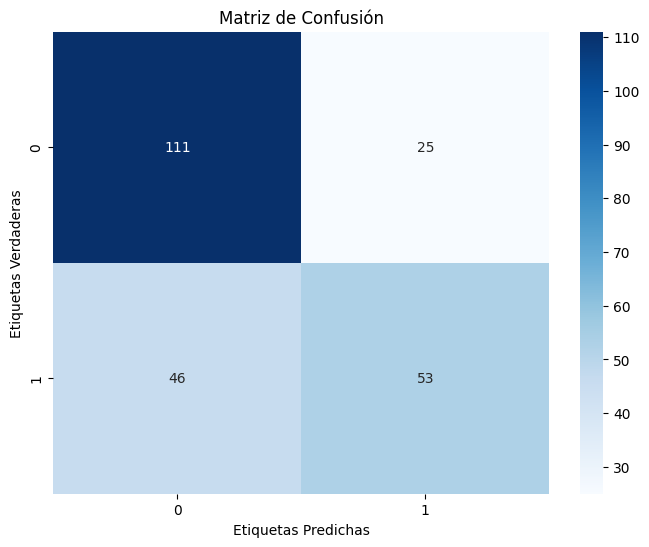

In [18]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.show()